<a href="https://colab.research.google.com/github/rajuc110/Beer-Ratings-and-Riviews/blob/main/beer_rating_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction
This data set is a Beer data-set we are expected to build a Machine Learning model which predicts the overall rating of the beer. (“review/overall” column in “train.csv” is your dependent variable.)
The .csv contains the following columns:
- index - an identifier for the review
- beer/ABV - the alcohol by volume of the beer
- beer/beerId - a unique ID indicating the beer reviewed
- beer/brewerId - a unique ID indicating the brewery
- beer/name - name of the beer
- beer/style
- review/appearance - rating of the beer's appearance (1.0 to 5.0)
- review/aroma - rating of the beer's aroma (1.0 to 5.0)
- review/overall - rating of the beer overall (1.0 to 5.0)
- review/palate - rating of the beer's palate (1.0 to 5.0)
- review/taste - rating of the beer's taste (1.0 to 5.0)
- review/text - the text of the review
- review/timeStruct - a dict specifying when the review was submitted
- review/timeUnix
- user/ageInSeconds - age of the user in seconds
- user/birthdayRaw
- user/birthdayUnix
- user/gender - gender of the user (if specified)
- user/profileName - profile name of the user



In [2]:
import pandas as pd
import numpy as np

In [3]:
beer_data=pd.read_csv('/content/drive/MyDrive/Data /train.csv')
beer_data.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


# Feature Extraction and Feature Engineering
We will remove the irrelevant features from the data set by looking at the number of missing data points in them and number of unique values present in the categorical features.
- Handling the missing data features
- Categorical Features
- review/text feature

Text(0.5, 1.0, '% of missing_data present in each feature')

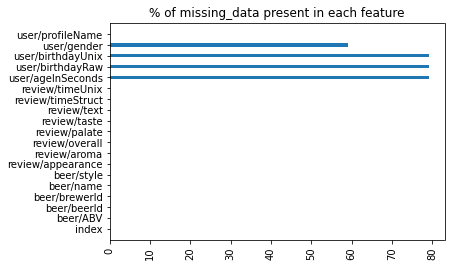

In [4]:
# remove those features which have missing data more than 50% of data points
missing_data=beer_data.isnull().sum()/len(beer_data)*100
import matplotlib.pyplot as plt
plt.figure()
plt.barh(missing_data.index,missing_data.values,height=0.3)
plt.xticks(rotation=90)
plt.title('% of missing_data present in each feature')

We will remove those columns which have missing values more than 50% of total data points, add these feature in the remove_col list and in the end remove all of them together 

In [5]:
remove_col=[col for col in beer_data.columns if beer_data[col].isnull().sum()/len(beer_data)*100 > 50]
remove_col

['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix', 'user/gender']

### Categorical Data
After removing the irrelevant features from the data set we will move forward to handle the Categorical features and extract the relevant information which make the feature more informative and understandable for the ML model.All the features
contains specific number classes in it, but most of them already present in integer or float datatype so these are not our concern, We will only look at those feature which are still present in string or character datatype.

In [6]:
cat_col=[col for col in beer_data.columns if beer_data[col].dtype=='object']
beer_data[cat_col].head()

,beer/name,beer/style,review/text,review/timeStruct,user/birthdayRaw,user/gender,user/profileName
0,Chiostro,Herbed / Spiced Beer,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",NaN,NaN,RblWthACoz
1,Bearded Pat's Barleywine,American Barleywine,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",NaN,NaN,BeerSox
2,Naughty Nellie's Ale,American Pale Ale (APA),First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",NaN,Male,mschofield
3,Pilsner Urquell,Czech Pilsener,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...","Aug 10, 1976",Male,molegar76
4,Black Sheep Ale (Special),English Pale Ale,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",NaN,NaN,Brewbro000


In [7]:
  #how many unique values each categorical column contains
unique=beer_data[cat_col].nunique()/len(beer_data)*100
unique

beer/name             4.501333
beer/style            0.253333
review/text          99.952000
review/timeStruct    99.973333
user/birthdayRaw      3.818667
user/gender           0.005333
user/profileName     19.842667
dtype: float64

Text(0.5, 1.0, '% of unique values present in Categorical features')

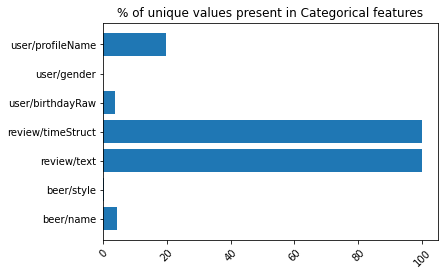

In [8]:
plt.figure()
plt.barh(unique.index,unique.values)
plt.xticks(rotation=45)
plt.title("% of unique values present in Categorical features")

In [9]:
# The review/timeStruct seems to be a irrelevant feature so we will remove it
remove_col=remove_col+['review/timeStruct']
beer_data.drop(remove_col,axis=1,inplace=True)
beer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeUnix    37500 non-null  int64  
 13  user/profileName   37495 non-null  object 
dtypes: float64(6), int64(4), object(4)
memory usage: 4.0+ MB


### review/text feature 
This feature seems to be a informative, We divide the review/text into 5 different groups these can be considered as excellent, good, neutral, bad, poor and label them by using Topic Modelling.

In [10]:
import nltk
beer_data.dropna(inplace=True)
beer_data.reset_index(inplace=True)
text=beer_data['review/text']
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import gensim
from gensim import corpora,models,matutils
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import re
exclude = set(string.punctuation)
stopword=set(stopwords.words('english'))
def clean_text(doc):
  text1=[i for i in doc.lower().split() if i not in stopword]
  text2=[i for i in text1 if i not in exclude]
  text3=[w for w in text2 if re.search('^\D',w)]
  #text4=[nltk.WordNetLemmatizer().lemmatize(i) for i in text3]
  text4=[nltk.PorterStemmer().stem(i) for i in text3]
  text5=" ".join([w for (w,pt) in nltk.pos_tag(text4) if pt=='JJ' or pt=='NN'])
  return text5
clean_text=text.apply(lambda x:clean_text(x))
clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0        pour cloud gold thin white head. nose quit flo...
1        bottl snifter. deep rubi red hue finger light ...
2        brewpub year final manag get bottle. slightli ...
3        first thing notic pour green bottl glass skunk...
4        pour finger head strong pour, head light layer...
                               ...                        
37480    brown longneck fresh dating. pour sa pint glas...
37481    bright red maroon-amb hue; minim light tan hea...
37482    sampl tap redbones. marzen style beer pour cle...
37483    pour black bodi brown head thin brown lace. ar...
37484    nice sweet, malti smooth refresh drink reveal ...
Name: review/text, Length: 37485, dtype: object

In [ ]:
#@title Default title text
dictnry=corpora.Dictionary([t.split() for t in clean_text])
corpus=[dictnry.doc2bow(w.split()) for w in clean_text]
tfidf_cp=models.TfidfModel(corpus,dictionary=dictnry)
lda=gensim.models.ldamodel.LdaModel
LDA=lda(corpus,id2word=dictnry,passes=30,num_topics=2)
LDA.print_topics(num_topics=2,num_words=10)
doc=[w.split() for w in clean_text]
topics=[doc for doc in LDA[corpus]]
beer_data['topics']=pd.Series([max(w,key=lambda x:x[1])[0] for w in topics])

In [ ]:
LDA.print_topics(num_topics=2,num_words=20)

[(0,
  '0.018*"dark" + 0.015*"beer" + 0.010*"roast" + 0.010*"chocol" + 0.009*"coffe" + 0.009*"pour" + 0.009*"flavor" + 0.009*"tast" + 0.009*"head" + 0.008*"sweet" + 0.008*"nice" + 0.007*"black" + 0.006*"alcohol" + 0.006*"brown" + 0.006*"good" + 0.006*"bit" + 0.006*"malt" + 0.005*"littl" + 0.005*"bitter" + 0.005*"smell"'),
 (1,
  '0.019*"hop" + 0.014*"beer" + 0.012*"nice" + 0.011*"malt" + 0.010*"sweet" + 0.010*"head" + 0.010*"tast" + 0.009*"light" + 0.009*"good" + 0.009*"pour" + 0.008*"bitter" + 0.008*"flavor" + 0.007*"bit" + 0.006*"white" + 0.006*"littl" + 0.006*"color" + 0.006*"aroma" + 0.006*"medium" + 0.005*"bodi" + 0.005*"smell"')]

In [ ]:
beer_data.nunique()

level_0              37485
index                37485
beer/ABV               126
beer/beerId           1731
beer/brewerId          212
beer/name             1688
beer/style              95
review/appearance       10
review/aroma             9
review/overall          10
review/palate            9
review/taste             9
review/text          37477
review/timeUnix      37475
user/profileName      7439
topics                   2
dtype: int64

In [ ]:
# remove some Unwanted columns here
beer_data.drop(['level_0','index','review/text','review/timeUnix','beer/beerId','user/profileName'],inplace=True,axis=1)

In [ ]:
beer_data.info()
#beer_data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37485 entries, 0 to 37484
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   beer/ABV           37485 non-null  float64
 1   beer/brewerId      37485 non-null  int64  
 2   beer/name          37485 non-null  object 
 3   beer/style         37485 non-null  object 
 4   review/appearance  37485 non-null  float64
 5   review/aroma       37485 non-null  float64
 6   review/overall     37485 non-null  float64
 7   review/palate      37485 non-null  float64
 8   review/taste       37485 non-null  float64
 9   topics             37485 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 2.9+ MB


# Exploratory Data Analysis: Graph and Visuals
We have prepared our dataset completely now we will do some visualization and try extract some insights from the visuals that we going to draw here.


import seaborn as sns
plt.figure()
sns.countplot(hue='review/overall',y='topics',data=beer_data)
plt.xticks(rotation=90)
#Most of the comments or text/reviews belong to rating of 4.0 in the datasets.

plt.figure()
sns.swarmplot(x=beer_data['review/overall'],y=beer_data['comment'])

In [ ]:
#To draw pairplot we extract feature which have unique value less 100
pp_col=[col for col in beer_data.columns if beer_data[col].nunique()<=10]
df_pp=beer_data[pp_col]
df_pp['review_nature']=beer_data['review/overall']>4.0
#we divided the data points on the basis of two classes in review_nature which gives nature of the overall/review 
#whether the review was positive or negative  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


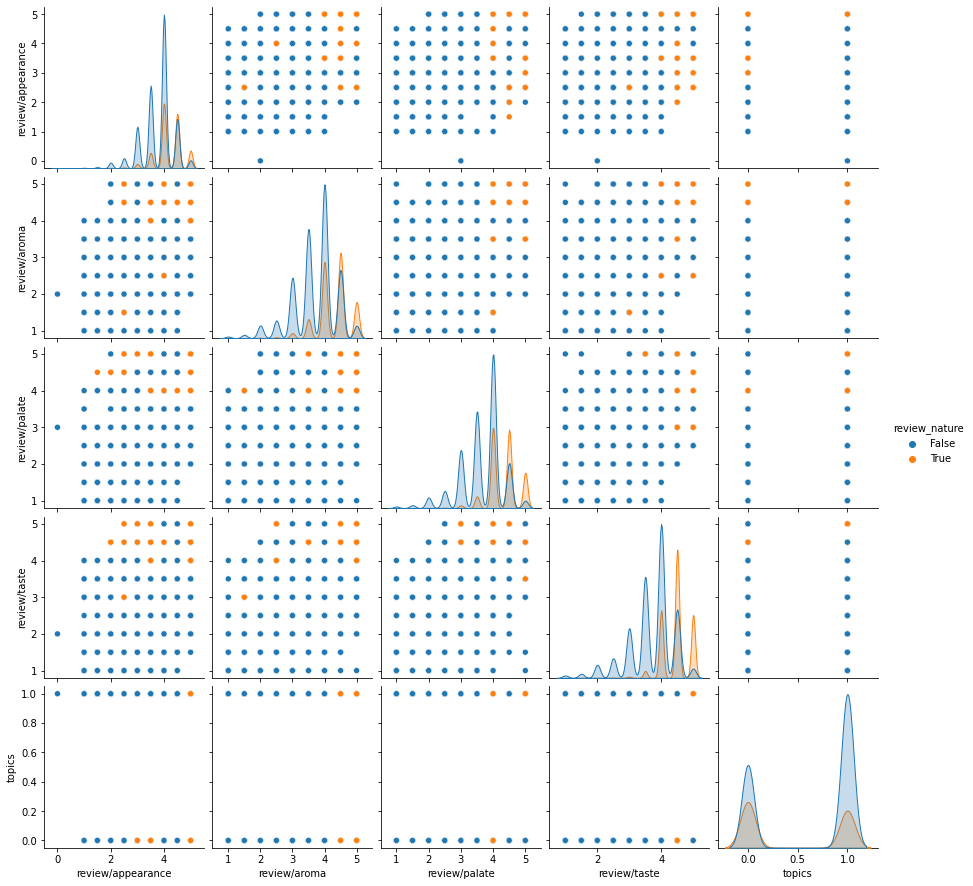

In [ ]:
import seaborn as sns
sns.pairplot(df_pp.drop('review/overall',axis=1),hue='review_nature')

By looking at the pairplot we can see that data points are not overlapping and data points are linearly seperable, so we will try to separate the data points by using linear function or Classifier.

<BarContainer object of 10 artists>

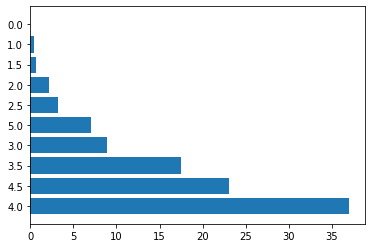

In [ ]:
plt.figure()
plt.barh(beer_data['review/overall'].value_counts().index.astype(str),beer_data['review/overall'].value_counts()/len(beer_data)*100)
# here we can see the Imbalanced data set, 4.0 rating has almost 40% of the sample

# Model Selection
- encoding of categorical variables
- Normalization/Feature Scaling
- Hyperparameter Tuning

In [ ]:
from sklearn.preprocessing import LabelEncoder
y=beer_data['review/overall']
X=beer_data.drop('review/overall',axis=1)
cat_col=[col for col in beer_data.columns if beer_data[col].dtype=='object']
print(cat_col)
encoder=LabelEncoder()
for col in cat_col:
    X[col]=encoder.fit_transform(beer_data[col])

['beer/name', 'beer/style']


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y)

# New Section

In [ ]:
column=X.columns
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X)
X_S=pd.DataFrame(scaler.transform(X),columns=column)
X_trainS=pd.DataFrame(scaler.transform(X_train),columns=column)
X_testS=pd.DataFrame(scaler.transform(X_test),columns=column)
X_S.head()

,beer/ABV,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/palate,review/taste,topics
0,0.085069,0.515794,0.218139,0.648936,0.8,0.750,0.750,0.750,1.0
1,0.189236,0.014175,0.090694,0.042553,0.8,0.625,0.625,0.500,1.0
2,0.079861,0.013095,0.618850,0.148936,0.7,0.750,0.625,0.625,1.0
3,0.074653,0.000000,0.695910,0.372340,0.6,0.500,0.500,0.500,1.0
4,0.074653,0.050943,0.136337,0.489362,0.8,0.500,0.625,0.375,1.0


In [ ]:
# Using Regression model for evaluation
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import cross_validate
model1=LinearRegression()
model2=Ridge()
model3=Lasso()
metric=('r2','neg_mean_squared_error','neg_mean_absolute_error')
cv_score1=pd.Series(cross_validate(model1,X_S,y,scoring=metric,cv=5))
cv_score2=pd.Series(cross_validate(model2,X_S,y,scoring=metric,cv=5))
cv_score3=pd.Series(cross_validate(model3,X_S,y,scoring=metric,cv=5))
Regression_df=pd.DataFrame([cv_score1.apply(lambda x:x.mean()),cv_score2.apply(lambda x:x.mean()),cv_score3.apply(lambda x:x.mean())],index=['Linear Regression','Ridge','Lasso']).drop(['fit_time','score_time'],axis=1)
Regression_df

,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error
Linear Regression,0.670917,-0.161351,-0.304939
Ridge,0.670912,-0.161354,-0.304883
Lasso,-0.000083,-0.490575,-0.522200


In [ ]:
#Using MultiClass Classification Model for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
model4=LogisticRegression(multi_class='ovr')
model4.fit(X_trainS,y_train.astype(str))
accuracy=accuracy_score(y_test.astype(str),model4.predict(X_testS))
precision=precision_score(y_test.astype(str),model4.predict(X_testS),average='micro')
recall=recall_score(y_test.astype(str),model4.predict(X_testS),average='micro')
f1=f1_score(y_test.astype(str),model4.predict(X_testS),average='micro')
con_matrix=confusion_matrix(y_test.astype(str),model4.predict(X_testS))
#plt.figure()
#sns.heatmap(con_matrix,annot=True)
print('accuracy:{}\nprecision:{}\nrecall:{}\nf1:{}'.format(accuracy,precision,recall,f1))

accuracy:0.4217883055911225
precision:0.4217883055911225
recall:0.4217883055911225
f1:0.4217883055911225


#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model6=SVC(kernel='rbf')
param_val={'gamma':[0.001,0.01,0.1,1,10],'C':[0.01,0.1,1,10,100]}
grid=GridSearchCV(model6,scoring='accuracy',param_grid=param_val)
grid.fit(X_trainS,y_train.astype(str))

In [ ]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
model5=LogisticRegression(multi_class='ovr')
grid_val={'C':[0.01,0.1,10,50,100,200,500,1000]}
grid=GridSearchCV(model5,param_grid=grid_val,scoring='accuracy')
grid.fit(X_trainS,y_train.astype(str))

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
accuracy_score(y_test.astype(str),grid.predict(X_testS))